# Does it work?

## TL;DR

The attributes that make the underlying survival model more accurate and useful from a game-level have a significant impact on how the metric rates players across the league; the metric becomes _contextual_, in that the same event under the same in-game conditions will be viewed differently based on exogenous factors such as schedule and team or opponent net rating. This effect is particularly visible with players on teams that have an extreme net rating.

The metric is limited by the gaps in traditional play-by-play data. We can only account for events that are explicitly logged; the effect of ball denial, "hockey" assists, individual defense, and other visible but implicit events will be severely underestimated.

In [1]:
import os
from pathlib import Path
import tempfile

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd

from nbaspa.data.endpoints.parameters import ParameterValues, SEASONS
from nbaspa.data.factory import NBADataFactory
from nbaspa.model.pipeline import gen_predict_pipeline, run_pipeline

In [2]:
calls = []
for season in SEASONS:
    for team in ParameterValues().TeamID:
        if team == 0:
            continue
        calls.append(("TeamLineups", {"TeamID": team, "Season": season, "output_dir": os.path.join(os.environ["DATA_DIR"], season)}))

In [3]:
loader = NBADataFactory(calls=calls)
_ = loader.load()

|████████████████████████████████████████| 480/480 [100%] in 4.2s (114.26/s)
[2021-10-20 03:52:35+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'Predict survival probability'
[2021-10-20 03:52:35+0000] INFO - prefect.TaskRunner | Task 'GameID': Starting task run...
[2021-10-20 03:52:35+0000] INFO - prefect.TaskRunner | Task 'GameID': Finished task run for task with final state: 'Success'
[2021-10-20 03:52:35+0000] INFO - prefect.TaskRunner | Task 'model': Starting task run...
[2021-10-20 03:52:35+0000] INFO - prefect.TaskRunner | Task 'model': Finished task run for task with final state: 'Success'
[2021-10-20 03:52:35+0000] INFO - prefect.TaskRunner | Task 'Load model': Starting task run...
[2021-10-20 03:52:35+0000] INFO - prefect.Load model | Reading model object from /app/GitHub/nba_survival/nba-data/models/2021-07-17/lifelines/model.pkl
[2021-10-20 03:52:35+0000] INFO - prefect.Load model | Reading model calibrator
[2021-10-20 03:52:35+0000] INFO - prefect.TaskRunner | T

[2021-10-20 03:52:36+0000] INFO - prefect.TaskRunner | Task 'filesystem': Starting task run...
[2021-10-20 03:52:36+0000] INFO - prefect.TaskRunner | Task 'filesystem': Finished task run for task with final state: 'Success'
[2021-10-20 03:52:36+0000] INFO - prefect.TaskRunner | Task 'output_dir': Starting task run...
[2021-10-20 03:52:36+0000] INFO - prefect.TaskRunner | Task 'output_dir': Finished task run for task with final state: 'Success'
[2021-10-20 03:52:36+0000] INFO - prefect.TaskRunner | Task 'Season': Starting task run...
[2021-10-20 03:52:36+0000] INFO - prefect.TaskRunner | Task 'Season': Finished task run for task with final state: 'Success'
[2021-10-20 03:52:36+0000] INFO - prefect.TaskRunner | Task 'model': Starting task run...
[2021-10-20 03:52:36+0000] INFO - prefect.TaskRunner | Task 'model': Finished task run for task with final state: 'Success'
[2021-10-20 03:52:36+0000] INFO - prefect.TaskRunner | Task 'GameID': Starting task run...
[2021-10-20 03:52:36+0000] INFO

In [4]:
overall = loader.get_data("Overall")
avg_rating = np.average(overall["E_NET_RATING"].values)

In [5]:
ratings = pd.concat(
    (
        pd.read_csv(fpath, sep="|", index_col=0, dtype={"GAME_ID": str})
        for fpath in Path(os.environ["DATA_DIR"]).glob("*/game-impact/data_*.csv")
    ),
    ignore_index=True
)

In [6]:
ratings.loc[
    ratings["GAME_ID"].str[3:5].astype(int) + 1 >= 10, "SEASON"
] = (
    ratings["GAME_ID"].str[2]
    + "0"
    + ratings["GAME_ID"].str[3:5]
    + "-"
    + (ratings["GAME_ID"].str[3:5].astype(int) + 1).astype(str)
)
ratings.loc[
    ratings["GAME_ID"].str[3:5].astype(int) + 1 < 10, "SEASON"
] = (
    ratings["GAME_ID"].str[2]
    + "0"
    + ratings["GAME_ID"].str[3:5]
    + "-0"
    + (ratings["GAME_ID"].str[3:5].astype(int) + 1).astype(str)
)

In [7]:
agg = ratings.groupby(["PLAYER_ID", "TEAM_ID", "SEASON"])[["IMPACT"]].sum()
agg = agg.loc[ratings.groupby(["PLAYER_ID", "TEAM_ID", "SEASON"])["GAME_ID"].count() > 50].copy()
agg.reset_index(inplace=True)

In [8]:
bin_result, edges = pd.qcut(overall["E_NET_RATING"], q=10, retbins=True)
edges = np.round(edges, 1)
bin_result.cat.rename_categories([f"{edges[i-1]} to {edges[i]}" for i in range(1, len(edges))], inplace=True)
overall["RATING_BIN"] = bin_result

## Review methodology

First, we will examine the relationship between SPA and the team net rating. If the metric is working as expected, we should see that "winning teams" have high impact players.

### Team-season aggregation

First, we will load the team net ratings for each team between 2006-07 and 2020-21. We will bin the team-seasons to deciles, and plot the distribution of SPA ratings.

In [9]:
agg_team = ratings.groupby(["TEAM_ID", "SEASON"])[["IMPACT"]].sum()
agg_team.reset_index(inplace=True)
agg_team["RATING_BIN"] = pd.merge(agg_team, overall, left_on=("TEAM_ID", "SEASON"), right_on=("TEAM_ID", "GROUP_VALUE"), how="left")["RATING_BIN"]

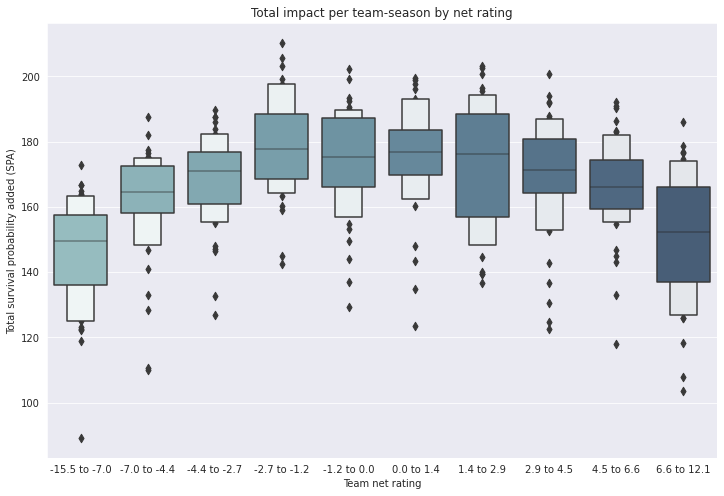

In [10]:
with sns.axes_style(style="darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxenplot(
        x="RATING_BIN",
        y="IMPACT",
        data=agg_team,
        palette=sns.cubehelix_palette(15, rot=-.25, light=0.7),
        ax=ax
    ).set(
        title="Total impact per team-season by net rating",
        xlabel="Team net rating",
        ylabel="Total survival probability added (SPA)"
    )

Interestingly, there is a sharp decline in total SPA for teams with extreme net rating values. Teams that have more neutral net ratings seem to be viewed more favourably by the metric.

### Player-season aggregation

Next, let's aggregate the game-level ratings to the player-season level to understand how players are viewed based on the context of their team quality.

In [11]:
agg["RATING_BIN"] = pd.merge(agg, overall, left_on=("TEAM_ID", "SEASON"), right_on=("TEAM_ID", "GROUP_VALUE"), how="left")["RATING_BIN"]

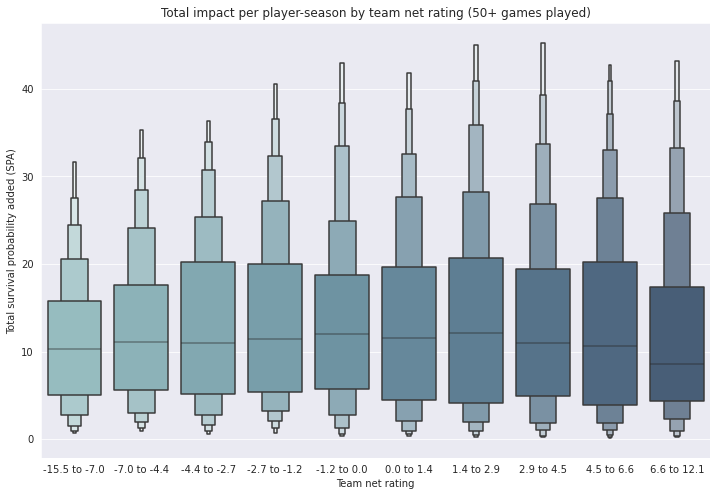

In [12]:
with sns.axes_style(style="darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxenplot(
        x="RATING_BIN",
        y="IMPACT",
        data=agg,
        showfliers=False,
        palette=sns.cubehelix_palette(15, rot=-.25, light=0.7),
        ax=ax
    ).set(
        title="Total impact per player-season by team net rating (50+ games played)",
        xlabel="Team net rating",
        ylabel="Total survival probability added (SPA)"
    )

This plot shows that players on teams with a net rating between -1.2 and 2.9 have the highest median SPA rating; somewhat surprisingly, players on elite teams (net rating 6.6-12.1) have a median SPA rating lower than players on terrible teams (net rating between -15.5 and -7).

However, team net rating is an input to the underlying time-varying Cox proportional hazards model. This means that team net rating is likely to influence how the model rates the impact of specific events. To analyze this, we will look at the distribution of pre-game win probability for each team. 

In [13]:
pregame = pd.concat(
    (
        pd.read_csv(fpath, sep="|", index_col=0, dtype={"GAME_ID": str})
        for fpath in Path(os.environ["DATA_DIR"]).glob("*/pregame-predictions.csv")
    ),
    ignore_index=True
)
home = pregame[["WIN_PROB", "HOME_NET_RATING"]].copy()
home.rename(columns={"HOME_NET_RATING": "NET_RATING"}, inplace=True)
visitor = pregame[["WIN_PROB", "VISITOR_NET_RATING"]].copy()
visitor.rename(columns={"VISITOR_NET_RATING": "NET_RATING"}, inplace=True)
visitor["WIN_PROB"] = 1 - visitor["WIN_PROB"]

gamepred = pd.concat([home, visitor], ignore_index=True)

In [14]:
gamepred["BIN"] = pd.cut(gamepred["NET_RATING"], bins=edges, include_lowest=True)
gamepred["BIN"].cat.rename_categories([f"{edges[i-1]} to {edges[i]}" for i in range(1, len(edges))], inplace=True)

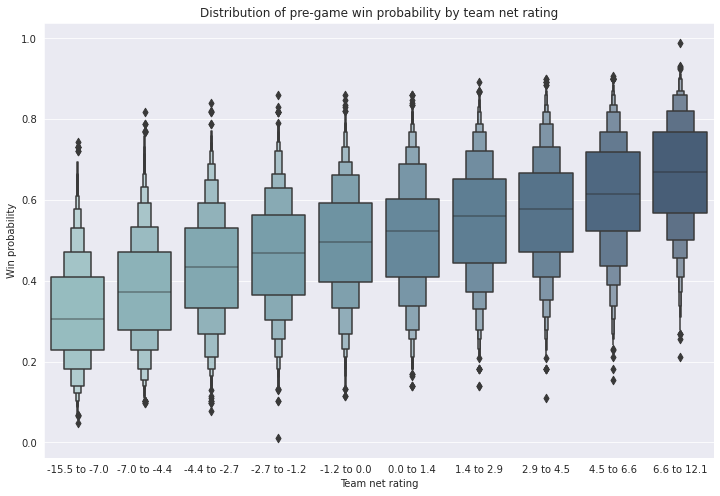

In [15]:
with sns.axes_style(style="darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxenplot(
        x="BIN",
        y="WIN_PROB",
        data=gamepred,
        palette=sns.cubehelix_palette(15, rot=-0.25, light=0.7),
        ax=ax
    ).set(
        title="Distribution of pre-game win probability by team net rating",
        xlabel="Team net rating",
        ylabel="Win probability"
    )

We can see that there is a clear relationship between the team net rating and the pre-game win probability.

### Examining the model sensitivity to net rating

Let's examine how the model reacts to net rating. To do this, we will create a simulated game with fixed exogenous variables and vary the net rating.

In [16]:
np.random.seed(5)
static = pd.DataFrame(
    {
        "GAME_ID": ["00219DUMMY10"],
        "HOME_W_PCT": [0.5],
        "VISITOR_W_PCT": [0.5],
        "LAST_GAME_WIN": [0],
        "HOME_GAMES_IN_LAST_3_DAYS": [0],
        "HOME_GAMES_IN_LAST_5_DAYS": [0],
        "HOME_GAMES_IN_LAST_7_DAYS": [0],
        "VISITOR_GAMES_IN_LAST_3_DAYS": [0],
        "VISITOR_GAMES_IN_LAST_5_DAYS": [0],
        "VISITOR_GAMES_IN_LAST_7_DAYS": [0],
        "HOME_NET_RATING": [0.0],
        "VISITOR_NET_RATING": [0.0],
    }
)
example = pd.DataFrame(
    {
        "GAME_ID": "00219DUMMY10",
        "TIME": np.concatenate(
            [np.zeros(1,), np.sort(np.random.randint(1, 2880, size=99))]
        ),
        "WIN": False,
        "NBA_WIN_PROB": np.round(np.random.uniform(0, 0.999, size=100), 3),
        "HOME_LINEUP_PLUS_MINUS": 0.0,
        "VISITOR_LINEUP_PLUS_MINUS": 0.0,
    }
)
example = pd.merge(example, static, left_on="GAME_ID", right_on="GAME_ID", how="left")
steps = np.random.choice(
    [-3, -2, 0, 2, 3], size=99, p=[0.025, 0.075, 0.75, 0.1, 0.05]
)
example["SCOREMARGIN"] = np.concatenate([np.zeros(1,), steps]).cumsum(0)
example.loc[99, "WIN"] = example.loc[99, "SCOREMARGIN"] > 0


In [17]:
with tempfile.TemporaryDirectory() as tmpdir:
    # Create output directory
    output_dir = Path(tmpdir, "2019-20", "model-data")
    output_dir.mkdir(parents=True, exist_ok=True)
    # Write the existing data to the temporary data
    example.to_csv(output_dir / "data_00219DUMMY10.csv", sep="|")
    # Raise the home team net rating
    for i in range(1, 5):
        tmp_df = example.copy()
        tmp_df["GAME_ID"] = f"00219DUMMY1{i}"
        tmp_df["HOME_NET_RATING"] += i * 2
        tmp_df.to_csv(output_dir / f"data_00219DUMMY1{i}.csv", sep="|")

    # Run the prediction pipeline
    flow = gen_predict_pipeline()
    run_pipeline(
        flow=flow,
        data_dir=tmpdir,
        output_dir=tmpdir,
        model=Path(os.environ["DATA_DIR"], "models", "2021-07-17", "lifelines", "model.pkl"),
        Season="2019-20"
    )

    # Load the output data back
    output = pd.concat(
        (
            pd.read_csv(fpath, sep="|", index_col=0, dtype={"GAME_ID": str})
            for fpath in Path(tmpdir, "2019-20", "survival-prediction").glob("data_*.csv")
        ),
        ignore_index=True
    )


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
df_list = []
for name, group in output.groupby("GAME_ID"):
    newid = int(name[-1])
    group["EVENT_IMPACT"] = group["WIN_PROB"].diff().bfill()
    if newid == 0:
        group["Home Net Rating"] = "Reference"
    else:
        group["Home Net Rating"] = f"+{newid * 2}"
    df_list.append(group)
    df_list[-1]["IMPACT_DIFF"] = df_list[-1]["EVENT_IMPACT"].abs().values - df_list[0]["EVENT_IMPACT"].abs().values
    
columns = ["Home Net Rating", "SCOREMARGIN", "TIME", "WIN_PROB", "EVENT_IMPACT", "IMPACT_DIFF"]

graphing = pd.concat(df_list, ignore_index=True)

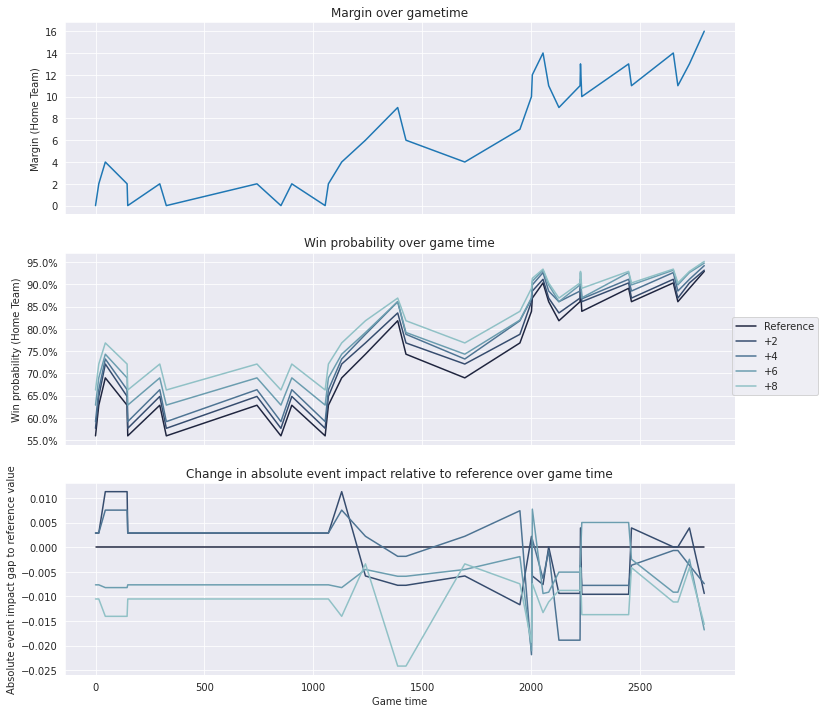

In [19]:
with sns.axes_style(style="darkgrid"):
    fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    palette = sns.cubehelix_palette(5, rot=-0.25, light=0.7, reverse=True)
    sns.lineplot(
        x="TIME",
        y="SCOREMARGIN",
        data=df_list[0],
        palette=palette,
        ax=axs[0]
    ).set(
        title="Margin over gametime",
        xlabel="Game time",
        ylabel="Margin (Home Team)"
    )
    sns.lineplot(
        x="TIME",
        y="WIN_PROB",
        data=graphing,
        hue="Home Net Rating",
        palette=palette,
        ax=axs[1]
    ).set(
        title="Win probability over game time",
        ylabel="Win probability (Home Team)"
    )
    axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    sns.lineplot(
        x="TIME",
        y="IMPACT_DIFF",
        hue="Home Net Rating",
        data=graphing,
        palette=palette,
        ax=axs[2]
    ).set(
        title="Change in absolute event impact relative to reference over game time",
        xlabel="Game time",
        ylabel="Absolute event impact gap to reference value"
    )
    # Single legend
    handles, labels = axs[2].get_legend_handles_labels()
    axs[1].get_legend().remove()
    axs[2].get_legend().remove()
    fig.legend(handles, labels, loc='right')

Based on the graph above, we can infer that net rating impacts both the initial win probability for a game as well as how the model rates the impact of a given event. Generally speaking, the shifts in win probability will be less drastic as net rating rises, and this is especially true when the win probability is low. As the win probability rises, the shifts from event to event will be similar between good and great teams.

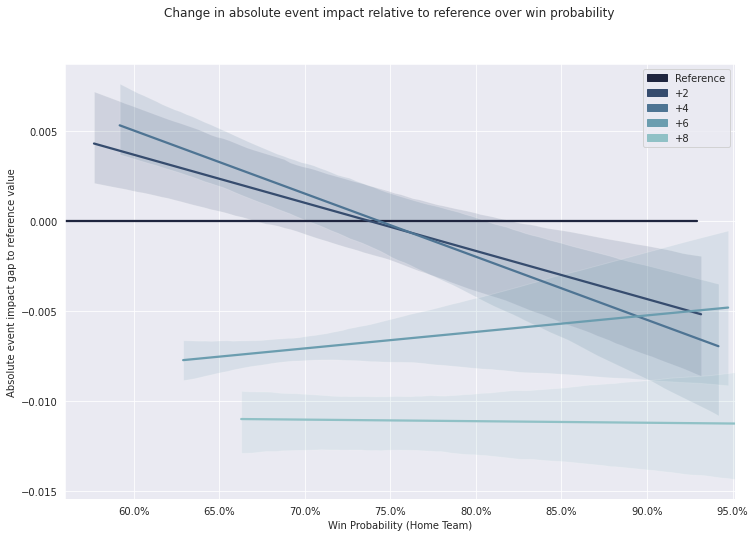

In [20]:
with sns.axes_style(style="darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    palette = sns.cubehelix_palette(5, rot=-0.25, light=0.7, reverse=True)
    handles = []
    for idx, val in enumerate(["Reference", "+2", "+4", "+6", "+8"]):
        sns.regplot(
            x="WIN_PROB",
            y="IMPACT_DIFF",
            data=graphing[graphing["Home Net Rating"] == val],
            color=palette[idx],
            scatter=False,
            ax=ax
        )
        handles.append(mpatches.Patch(color=palette[idx], label=val))
    
    fig.suptitle("Change in absolute event impact relative to reference over win probability")
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    ax.set_xlabel("Win Probability (Home Team)")
    ax.set_ylabel("Absolute event impact gap to reference value")
    ax.legend(handles=handles)

Additionally, a high net rating implies that a given team is playing more minutes with a large lead. Let's repeat the experiment above, but instead of varying home net rating we will vary the margin of the game.

In [21]:
with tempfile.TemporaryDirectory() as tmpdir:
    # Create output directory
    output_dir = Path(tmpdir, "2019-20", "model-data")
    output_dir.mkdir(parents=True, exist_ok=True)
    # Write the existing data to the temporary data
    example.to_csv(output_dir / "data_00219DUMMY10.csv", sep="|")
    
    for i in range(1, 5):
        tmp_df = example.copy()
        tmp_df["GAME_ID"] = f"00219DUMMY1{i}"
        tmp_df["SCOREMARGIN"] += i * 5
        tmp_df.to_csv(output_dir / f"data_00219DUMMY1{i}.csv", sep="|")

    # Run the prediction pipeline
    flow = gen_predict_pipeline()
    run_pipeline(
        flow=flow,
        data_dir=tmpdir,
        output_dir=tmpdir,
        model=Path(os.environ["DATA_DIR"], "models", "2021-07-17", "lifelines", "model.pkl"),
        Season="2019-20"
    )

    # Load the output data back
    output = pd.concat(
        (
            pd.read_csv(fpath, sep="|", index_col=0, dtype={"GAME_ID": str})
            for fpath in Path(tmpdir, "2019-20", "survival-prediction").glob("data_*.csv")
        ),
        ignore_index=True
    )


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df_list = []
for name, group in output.groupby("GAME_ID"):
    newid = int(name[-1])
    if newid == 0:
        group["Margin"] = "Reference"
    else:
        group["Margin"] = f"+{newid * 5}"
    group["EVENT_IMPACT"] = group["WIN_PROB"].diff().bfill()
    df_list.append(group)
    df_list[-1]["IMPACT_DIFF"] = df_list[-1]["EVENT_IMPACT"].abs().values - df_list[0]["EVENT_IMPACT"].abs().values
    
columns = ["Margin", "SCOREMARGIN", "TIME", "WIN_PROB", "EVENT_IMPACT", "IMPACT_DIFF"]

graphing = pd.concat(df_list, ignore_index=True)

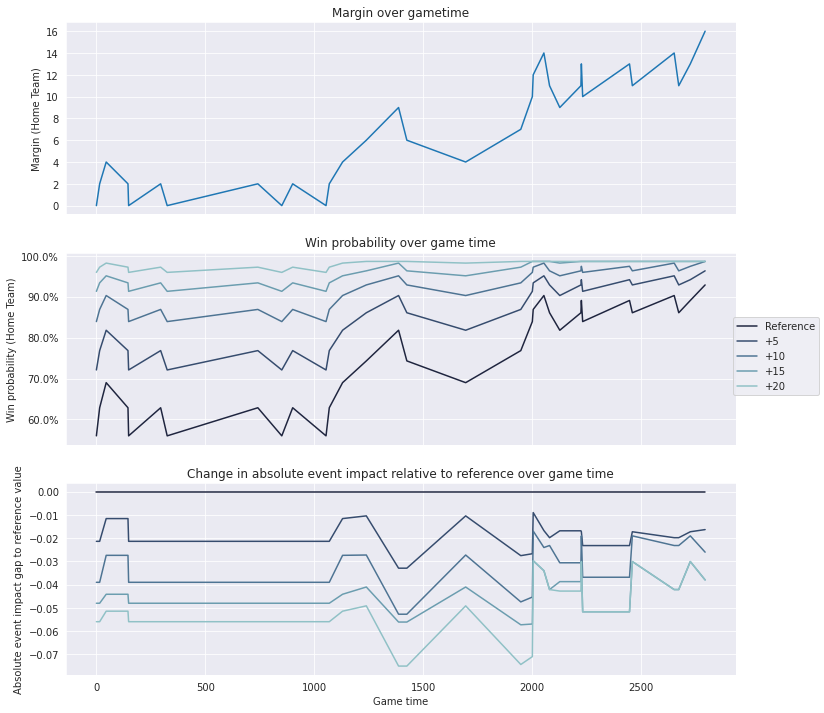

In [23]:
with sns.axes_style(style="darkgrid"):
    fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    sns.lineplot(
        x="TIME",
        y="SCOREMARGIN",
        data=df_list[0],
        ax=axs[0]
    ).set(
        title="Margin over gametime",
        xlabel="Game time",
        ylabel="Margin (Home Team)"
    )
    sns.lineplot(
        x="TIME",
        y="WIN_PROB",
        hue="Margin",
        data=graphing,
        palette=sns.cubehelix_palette(5, rot=-0.25, light=0.7, reverse=True),
        ax=axs[1]
    ).set(
        title="Win probability over game time",
        ylabel="Win probability (Home Team)"
    )
    axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    sns.lineplot(
        x="TIME",
        y="IMPACT_DIFF",
        hue="Margin",
        data=graphing,
        palette=sns.cubehelix_palette(5, rot=-0.25, light=0.7, reverse=True),
        ax=axs[2]
    ).set(
        title="Change in absolute event impact relative to reference over game time",
        xlabel="Game time",
        ylabel="Absolute event impact gap to reference value"
    )
    # Single legend
    handles, labels = axs[2].get_legend_handles_labels()
    axs[1].get_legend().remove()
    axs[2].get_legend().remove()
    fig.legend(handles, labels, loc='right')

Intuitively, the model discounts the impact of events in games with a high scoring margin. So, players will be evaluated differently based on how good their team is as well as the margin of the game; as a result, players on good teams will have a lower SPA rating than players on more neutral teams.

### Adjusting the raw SPA ratings by removing contextual information

So, we know that SPA ratings will be sensitive to the contextual variables for each game; a basket scored by a player on a well-rested, highly rated team will be viewed as less impactful than a basket scored by a player on a mediocre team that played last night. However, we should ask: how would the ratings change if we isolated them to the direct actions players take during the game? To answer this question, we regenerated the play-by-play survival probability for every game with no contextual information -- just time and score.

In [24]:
ratings_plus = pd.concat(
    (
        pd.read_csv(fpath, sep="|", index_col=0, dtype={"GAME_ID": str})
        for fpath in Path(os.environ["DATA_DIR"]).glob("*/game-impact-plus/data_*.csv")
    ),
    ignore_index=True
)

In [25]:
ratings_plus.loc[
    ratings_plus["GAME_ID"].str[3:5].astype(int) + 1 >= 10, "SEASON"
] = (
    ratings_plus["GAME_ID"].str[2]
    + "0"
    + ratings_plus["GAME_ID"].str[3:5]
    + "-"
    + (ratings_plus["GAME_ID"].str[3:5].astype(int) + 1).astype(str)
)
ratings_plus.loc[
    ratings_plus["GAME_ID"].str[3:5].astype(int) + 1 < 10, "SEASON"
] = (
    ratings_plus["GAME_ID"].str[2]
    + "0"
    + ratings_plus["GAME_ID"].str[3:5]
    + "-0"
    + (ratings_plus["GAME_ID"].str[3:5].astype(int) + 1).astype(str)
)

In [26]:
agg_plus = ratings_plus.groupby(["PLAYER_ID", "TEAM_ID", "SEASON"])[["IMPACT"]].sum()
agg = agg_plus.loc[ratings_plus.groupby(["PLAYER_ID", "TEAM_ID", "SEASON"])["GAME_ID"].count() > 50].copy()
agg_plus.reset_index(inplace=True)

In [27]:
agg_plus["RATING_BIN"] = pd.merge(agg_plus, overall, left_on=("TEAM_ID", "SEASON"), right_on=("TEAM_ID", "GROUP_VALUE"), how="left")["RATING_BIN"]

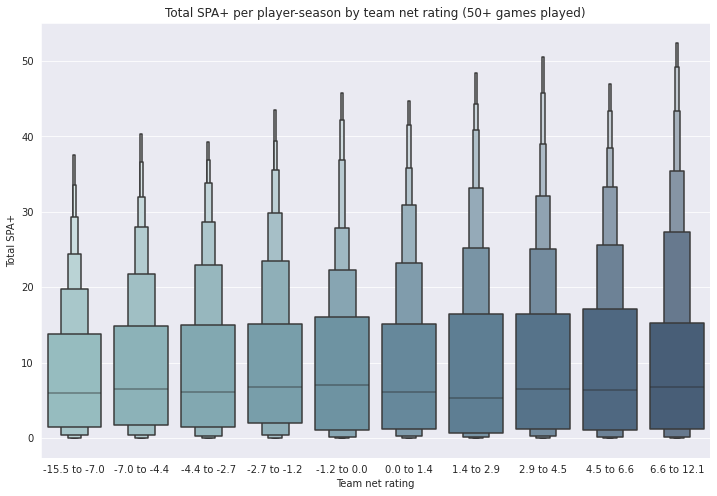

In [28]:
with sns.axes_style(style="darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.boxenplot(
        x="RATING_BIN",
        y="IMPACT",
        data=agg_plus,
        showfliers=False,
        palette=sns.cubehelix_palette(15, rot=-.25, light=0.7),
        ax=ax
    ).set(
        title="Total SPA+ per player-season by team net rating (50+ games played)",
        xlabel="Team net rating",
        ylabel="Total SPA+"
    )

In our view, the graph above is more balanced. Players on elite teams have the highest peak total impact, although the sum total might still be affected by playing in low-leverage, high margin games. In the end, we are satisfied with the insight this adjustment gives.